In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("heitornunes/uiuc-propeller-database")

print("Path to dataset files:", path)

100%|██████████| 376k/376k [00:00<00:00, 936kB/s]

Extracting files...
Path to dataset files: C:\Users\Piotr\.cache\kagglehub\datasets\heitornunes\uiuc-propeller-database\versions\1


In [7]:
import numpy as np
import pandas as pd 
import os

In [ ]:
from sklearn.model_selection import train_test_split

class DataCreator:
    def __init__(self, target_key):
        self.path = ''
        self.input_keys = ['B', 'D', 'P', 'J', 'N', 'c/R', 'r/R', 'beta']
        self.output_keys = ['CT', 'CP', 'eta']
        self.target_key = target_key
        
    # Create geometric dataframe
    def geom_data(self):
        # Directories of geometric data
        geom1_dir = os.path.join(self.path, 'volume1_geom.csv')
        geom2_dir = os.path.join(self.path, 'volume2_geom.csv')
        geom3_dir = os.path.join(self.path, 'volume3_geom.csv')
        
        # Geometric data from volume 1 to volume 3
        geom1_df = pd.read_csv(geom1_dir)
        geom2_df = pd.read_csv(geom2_dir)
        geom3_df = pd.read_csv(geom3_dir)
        
        # Merge them into 1 geom dataframe
        geom_df = pd.concat([geom1_df, geom2_df, geom3_df], ignore_index=True)
        
        return geom_df
    
    # Create performance dataframe
    def perf_data(self):
        # Directories of performance data
        perf1_dir = os.path.join(self.path, 'volume1_exp.csv')
        perf2_dir = os.path.join(self.path, 'volume2_exp.csv')
        perf3_dir = os.path.join(self.path, 'volume3_exp.csv')
        
        # Performance data from volume 1 to volume 3
        perf1_df = pd.read_csv(perf1_dir)
        perf2_df = pd.read_csv(perf2_dir)
        perf3_df = pd.read_csv(perf3_dir)
        
        # Merge them into 1 perf dataframe
        perf_df = pd.concat([perf1_df, perf2_df, perf3_df], ignore_index=True)
        
        return perf_df
    
    # Create df dataframe
    def df(self):
        geom_df = self.geom_data()
        perf_df = self.perf_data()
        df = perf_df.merge(geom_df, on=['BladeName', 'D', 'P', 'Family'])
        return df
    
    # Split df into X and y
    def X_y(self):
        df = self.df()
        X = df[self.input_keys].values
        y = df[self.output_keys].values
        return X, y
    
    # Chose the y target
    def target_y(self):
        __, y = self.X_y()
        return y[:, self.output_keys.index(self.target_key)]
    
    # Split X and y into train and test data
    def train_test(self):
        X, __ = self.X_y()
        y = self.target_y()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
        
        return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
import random
import matplotlib.pyplot as plt
class DTR:
    def __init__(self, target_key, degree=1):
        self.target_key = target_key
        self.input_keys = DataCreator(target_key=self.target_key).input_keys
        self.output_keys = DataCreator(target_key=self.target_key).output_keys
    # X and y
    def X_y(self):
        X_train, X_test, y_train, y_test = DataCreator(target_key = self.target_key).train_test()
        return X_train, X_test, y_train, y_test
    # Model 
    def model(self):
        model = DecisionTreeRegressor()
        return model
    # Fitting the model
    def fitter(self):
        model = self.model()
        X_train, __, y_train, __ = self.X_y()
        model.fit(X_train, y_train)
        return model
    # Making a prediction
    def pred(self):
        model = self.fitter()
        __, X_test, __, __ = self.X_y()
        y_pred = model.predict(X_test)
        return y_pred
    # Calculate the error
    def error(self):
        __, __, __, y_true = self.X_y()
        y_pred = self.pred()
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        data = [['mae', mae], ['mse', mse]]
        header = ['Metric', 'Value']
        error_tab = tabulate(data, header, tablefmt='grid')
        return error_tab
    # Plotting error table
    def err_tab(self):
        error_tab = self.error()
        print(error_tab)
    # Chose propeller randomly
    def prop_data(self):
        while True:
            df = DataCreator(target_key=self.target_key).df()
            random_prop_name = random.choice(df['PropName'])
            df = df[df['PropName'] == random_prop_name]
            random_rpm = random.choice(list(df['N']))
            df = df[df['N'] == random_rpm]
            y_true = df[self.target_key]
            model = self.fitter()
            y_pred = model.predict(df[self.input_keys].values)
            adv = df['J']
            if sum(adv) != 0:
                return adv, y_true, y_pred
    # Plot some results
    def plotter(self):
        adv, y_true, y_pred = self.prop_data()
        plt.plot(adv, y_true, 'og', label='Actual')
        plt.plot(adv, y_pred, '-r', label='Predicted')
        plt.legend()
        plt.show()

In [12]:
DTR(target_key='CP').err_tab()

+----------+-------------+
| Metric   |       Value |
+==========+=============+
| mae      | 0.000131009 |
+----------+-------------+
| mse      | 1.66098e-06 |
+----------+-------------+


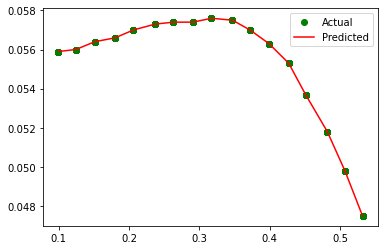

In [14]:
DTR(target_key='CP').plotter()